# Step 1 — 一维元胞自动机（ECA）入门：规则 → 模拟 → 空间–时间图

本 Notebook 面向初学者，目标是：
1. 把 Wolfram 规则号（0–255）转成 8 位规则表（truth table）
2. 根据规则与初态，模拟一维 ECA 的演化轨迹
3. 绘制经典的空间–时间图（Space–Time Diagram）

我们将采用最小依赖（仅 numpy、matplotlib），并在每段代码之前用中文解释其作用，代码内部注释也全部用中文，方便你加笔记或修改实验参数。

## 背景与术语说明
- ECA（Elementary Cellular Automata）：一维、二值（0/1）、半径 r=1 的最简单元胞自动机。每个格点的下一时刻仅依赖于它自己与左右各 1 个邻居，共 3-bit 邻域，因此共有 8 种邻域模式，每种模式的输出是 0 或 1。
- Wolfram 规则号（0–255）：把 8 个输出位按固定顺序（通常从邻域 111 到 000）拼成一个 8 位二进制数，再解读为十进制，即得到规则号。例如 Rule 30、Rule 110。
- 空间–时间图：把每一行显示为一个时刻的整条状态（长度为 L 的 0/1 序列），从上到下显示随时间演化的图案。

> 位序约定：bits[k] 表示邻域模式的输出，其中索引 k 的二进制写法即为邻域从左到右的比特（left, center, right）。例如，k=0 表示模式 000，k=7 表示 111。

## 规则号 → 8-bit 规则表

下面的函数 `eca_rule_bits`：
- 输入一个 `rule_id ∈ [0, 255]`。
- 通过位运算，依次取出该规则号的 8 个二进制位，返回为长度为 8 的数组。
- 索引与邻域的对应关系：索引 0 → 邻域 000，……，索引 7 → 邻域 111。

In [2]:
import numpy as np

def eca_rule_bits(rule_id: int) -> np.ndarray:
    """
    ASCII-only docstring:
    Convert Wolfram rule_id [0,255] into a length-8 bit table.
    Index 0 -> neighborhood 000, index 7 -> 111.
    Return uint8 array of 8 bits.
    """
    # 参数检查：必须在 0..255 之间
    if not (0 <= rule_id <= 255):
        raise ValueError("rule_id 必须在 [0, 255] 之间")
    # 通过右移与按位与取出 8 个二进制位（k 从 0 到 7）
    bits = np.array([(rule_id >> k) & 1 for k in range(8)], dtype=np.uint8)
    return bits

# 小测试：打印 Rule 30 的 8 位规则表
rule_id = int(input())
print("Rule", rule_id, "的 8-bit（索引0=000，索引7=111）:", eca_rule_bits(rule_id))

Rule 30 的 8-bit（索引0=000，索引7=111）: [0 1 1 1 1 0 0 0]


## ECA 单步更新与多步模拟

实现两个函数：
- `eca_step(state, bits, periodic)`: 对当前状态做一次更新；用位运算把 (left, center, right) 组成索引 k，在 bits[k] 查表得到输出。
- `simulate_eca(rule_id, L, T, x0, periodic, seed)`: 做 T 步模拟，返回 (T+1, L) 的轨迹数组与规则表 bits。

In [3]:
from typing import Optional, Tuple

def eca_step(state: np.ndarray, bits: np.ndarray, periodic: bool = True) -> np.ndarray:
    """
    ASCII-only docstring:
    Do one ECA update step with radius r=1.
    """
    L = state.size
    # 取左右邻居（根据边界条件）
    if periodic:
        # 周期边界：首尾相连（环形）
        left  = np.roll(state, +1)
        right = np.roll(state, -1)
    else:
        # 非周期边界：边界外补 0
        left  = np.empty_like(state)
        right = np.empty_like(state)
        left[0]  = 0
        left[1:] = state[:-1]
        right[-1] = 0
        right[:-1] = state[1:]

    # 把 (left, center, right) 拼成 0..7 的索引： (left<<2)|(center<<1)|right
    pat = (left << 2) | (state << 1) | right
    # 根据规则表查出输出并返回
    return bits[pat].astype(np.uint8)


def simulate_eca(rule_id: int, L: int, T: int,
                 x0: Optional[np.ndarray] = None,
                 periodic: bool = True,
                 seed: Optional[int] = 0) -> Tuple[np.ndarray, np.ndarray]:
    """
    ASCII-only docstring:
    Simulate T steps and return trajectory (T+1, L) and bits.
    """
    rng = np.random.default_rng(seed)
    bits = eca_rule_bits(rule_id)

    # 若未提供初态，则随机生成 0/1 序列
    if x0 is None:
        x0 = rng.integers(0, 2, size=L, dtype=np.uint8)

    # 轨迹数组：第 0 行是初态，第 t+1 行是第 t 步后的状态
    traj = np.empty((T+1, L), dtype=np.uint8)
    traj[0] = x0
    for t in range(T):
        traj[t+1] = eca_step(traj[t], bits, periodic=periodic)
    return traj, bits

# 小测试：长度 16，步数 8 的 Rule 30
traj_demo, bits_demo = simulate_eca(30, L=16, T=8, seed=42)
print(traj_demo[0])
traj_demo

[1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0]


array([[1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]], dtype=uint8)

## 空间–时间图可视化函数

把轨迹 (T+1, L) 画成二维图（横轴空间 i，纵轴时间 t）。本函数不强制指定颜色映射，默认配色已能看出结构；如需黑白样式，可把数据转为 1 - traj 或传入自定义 colormap。

C:\Users\98690\anaconda3\envs\nusjupyter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\98690\anaconda3\envs\nusjupyter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\98690\anaconda3\envs\nusjupyter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\98690\anaconda3\envs\nusjupyter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\98690\anaconda3\envs\nusjupyter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28436 (\N{CJK UNIF

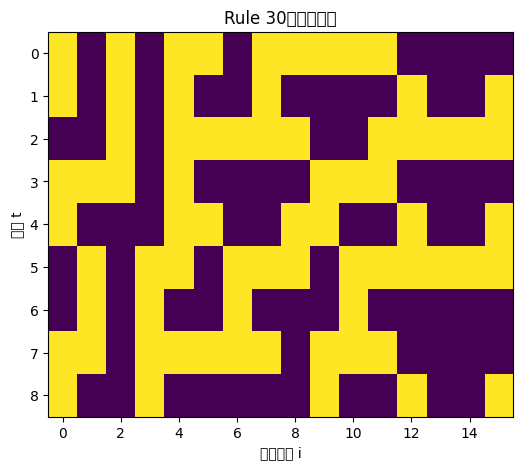

In [4]:
import matplotlib.pyplot as plt

def plot_spacetime(traj: np.ndarray, title: str = "") -> None:
    """
    ASCII-only docstring:
    Plot space-time diagram for trajectory of shape (T+1, L).
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    # 最近邻插值让像素边界清晰
    ax.imshow(traj, aspect="auto", interpolation="nearest", origin="upper")
    ax.set_xlabel("空间索引 i")
    ax.set_ylabel("时间 t")
    if title:
        ax.set_title(title)
    plt.show()

# 演示：画出上一个小测试的结果
plot_spacetime(traj_demo, title="Rule 30（小演示）")

## 主实验：随机初态 + 指定规则的演化与绘图

可修改以下参数：RULE_ID, L, T, SEED, PERIODIC。运行后会打印 8-bit 规则表（索引 0=000），并绘制空间–时间图。

该规则的 8-bit: [0 1 1 1 0 1 1 0]


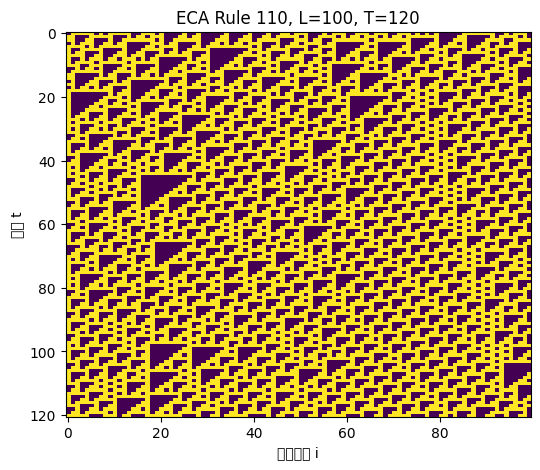

In [5]:
# ===== 主实验参数（可修改） =====
RULE_ID = 110
L        = 100
T        = 120
SEED     = 0
PERIODIC = True

traj, bits = simulate_eca(RULE_ID, L=L, T=T, seed=SEED, periodic=PERIODIC)
print("该规则的 8-bit:", bits)  # 索引0=邻域000，索引7=111
plot_spacetime(traj, title=f"ECA Rule {RULE_ID}, L={L}, T={T}")

## 典型“单点初态”演化（便于观察三角纹理）

构造一个“单点初态”（只有中间一个 1），再用指定规则演化，常见的三角形/分形结构会非常清晰。

C:\Users\98690\anaconda3\envs\nusjupyter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\98690\anaconda3\envs\nusjupyter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\98690\anaconda3\envs\nusjupyter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\98690\anaconda3\envs\nusjupyter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


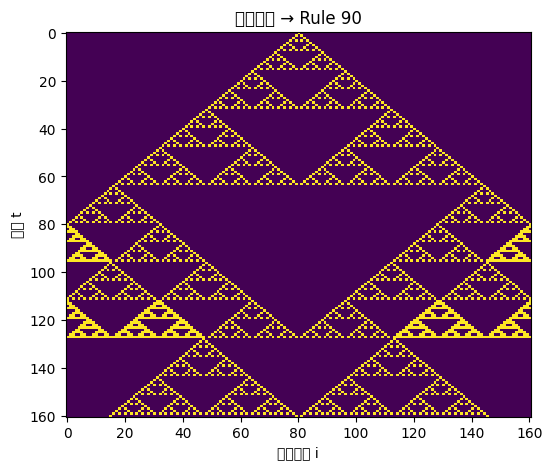

In [6]:
RULE_ID_spike = 90
L_spike = 161
T_spike = 160
PERIODIC_spike = True

# 构造单点初态（中间为 1）
x0 = np.zeros(L_spike, dtype=np.uint8)
x0[L_spike // 2] = 1

traj_spike, _ = simulate_eca(RULE_ID_spike, L=L_spike, T=T_spike,
                             x0=x0, periodic=PERIODIC_spike, seed=None)
plot_spacetime(traj_spike, title=f"单点初态 → Rule {RULE_ID_spike}")

## 多规则对比：一次画出多条规则的空间–时间图

用相同规模的实验参数对多条规则进行对比，便于快速形成直觉。

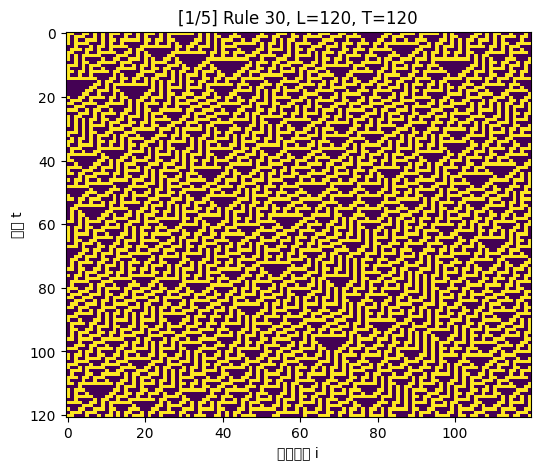

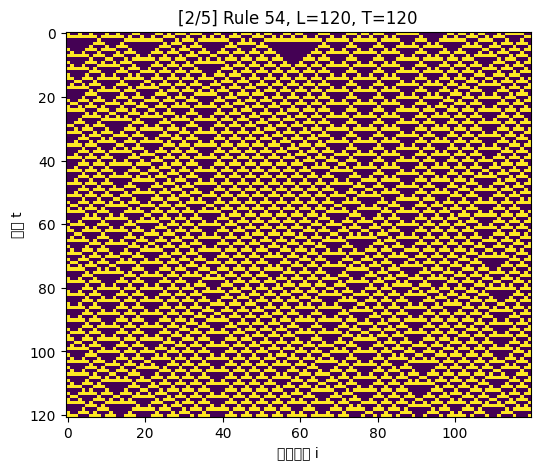

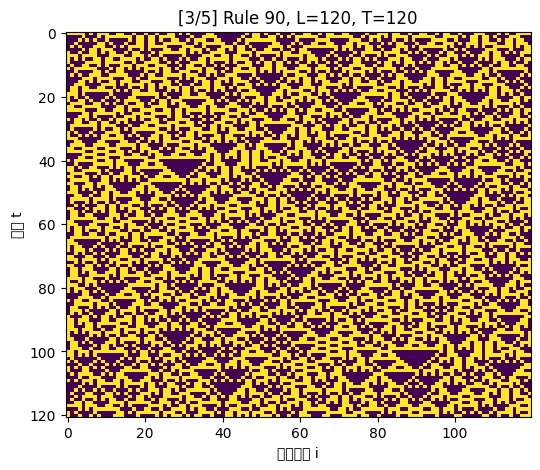

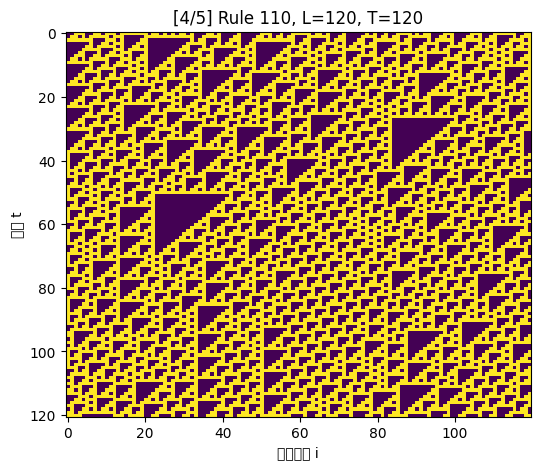

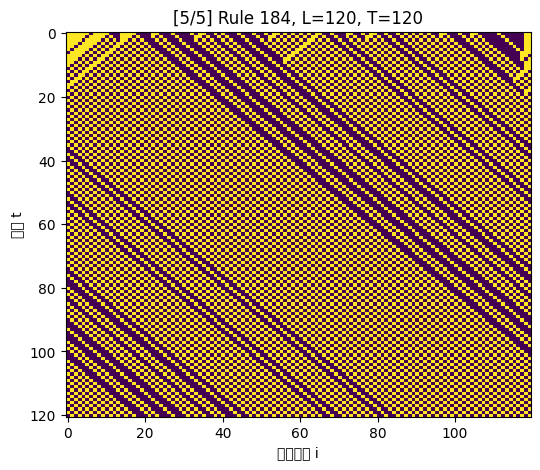

In [7]:
rule_list = [30, 54, 90, 110, 184]
L_cmp = 120
T_cmp = 120

for idx, rid in enumerate(rule_list, 1):
    traj_cmp, _ = simulate_eca(rid, L=L_cmp, T=T_cmp, seed=idx, periodic=True)
    plot_spacetime(traj_cmp, title=f"[{idx}/{len(rule_list)}] Rule {rid}, L={L_cmp}, T={T_cmp}")

## 延伸阅读与下一步建议

- 参数扫描：批量扫描 rule_id ∈ [0,255]，保存缩略图，快速浏览规则空间。
- 汉明距离传播：复制初态并翻转一个比特，比较两条轨迹的汉明距离随时间变化，为后续分类/相变研究打基础。
- 图表示（下一步）：把 (i,t) 作为图节点，连时间边与空间边，保存为图学习框架可读的数据结构。
- 2D 扩展：实现 Game of Life 等 2D 规则，并用帧序列可视化。